In [1]:
#librerie
import os
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn import metrics
import random as rd
from sklearn.svm import SVC
from google.colab import drive
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [2]:
!pip install kneed
from kneed import KneeLocator

In [3]:
drive.mount('/content/drive/', force_remount=True)
#GDrivePath = '/content/drive/MyDrive/CV_progetto2'

Mounted at /content/drive/


In [4]:
# Funzione per leggere le immagini e creare una lista di etichette
def load_images_labels(principal_folder):
    """
      Loads valid image file paths and their associated labels from a structured directory.

      Parameters:
        principal_folder (str): Path to the main directory containing labeled subfolders.
                                Each subfolder represents a class label and contains image files.

      Returns:
          images (list of str): List of valid image file paths.
          labels (list of str): List of labels corresponding to each image, based on subfolder names.
    """

    labels = []
    images = []

    for folder in os.listdir(principal_folder):
        folder_path = os.path.join(principal_folder, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    try:
                        img = Image.open(file_path)
                        img.verify()

                        # Save image and its label
                        images.append(file_path)
                        labels.append(folder)
                    except (IOError, SyntaxError):
                        # If the image is corrupted, ignore it
                        continue

    return images, labels


#Assignment 1#
build a visual vocabulary:


*   sample many (10K to 100K) SIFT descriptors from the images of
the training set (you either use a detector or sample on a grid in the
scale-space);
*  cluster them using k-means (the choice of the number of clusters is
up to you, and you should experiment with different values, but you
could start with a few dozens);
*  collect (and save for future use) the clusters’ centroids which repre-
sent the k 128-dimensional visual words.

In [5]:
# upload image training
folder_training = '/content/drive/MyDrive/CV_progetto2/train'
images_training, train_labels  = load_images_labels(folder_training)
print(len(images_training))

1500


In [6]:
# find the classes
labels = np.unique(train_labels)
print(labels)
n_classes = len(labels)
print(n_classes)

['Bedroom' 'Coast' 'Forest' 'Highway' 'Industrial' 'InsideCity' 'Kitchen'
 'LivingRoom' 'Mountain' 'Office' 'OpenCountry' 'Store' 'Street' 'Suburb'
 'TallBuilding']
15


modifiche apportabili:


1.   verifica come e se vengono già identificate le zone affini prima di calcolare il sift



**Comments**


---


The images are converted to grayscale because SIFT descriptors do not explicitly use color information. Texture and shape are not influenced by color, so it is sufficient to use a single channel, which results in lower memory usage and better computational efficiency.
For each image, 60 keypoints are detected, so with 1,500 images, we obtain $60*1500=90000$ descriptors that can be used to compute the visual vocabulary.

In [7]:
# SIFT descriptors
all_descriptors = []
k_p = 60  #60*1500 = 90000 descriptors in total
for image_path in images_training:
    # grey scale image conversion
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create(k_p)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        all_descriptors.append(descriptors)
all_descriptors = np.vstack(all_descriptors)

The number of visual words was determined using a grid search with the K-Means algorithm. The following metrics were used to identify a good number of clusters:  

*   Inertia: Measures the internal cohesion of the clusters. Lower inertia
indicates higher cohesion, but the value naturally decreases as the number of clusters increases.
*   Silhouette Score: Measures the separation between clusters. It evaluates how well each point fits within its assigned cluster compared to others.

To find the optimal value of kk, it is necessary to look for a high silhouette score and low inertia, balancing both compactness and separation.

The best value at this point is chosen to be k = 48



For k = 12 | Silhouette Score = 0.0625
For k = 24 | Silhouette Score = 0.0567
For k = 36 | Silhouette Score = 0.0536
For k = 48 | Silhouette Score = 0.0503
For k = 60 | Silhouette Score = 0.0488
For k = 72 | Silhouette Score = 0.0466
For k = 84 | Silhouette Score = 0.0467
For k = 96 | Silhouette Score = 0.0438
For k = 108 | Silhouette Score = 0.0418

--- Summary ---
Optimal k by Elbow Method: 48
Optimal k by Silhouette Score: 12


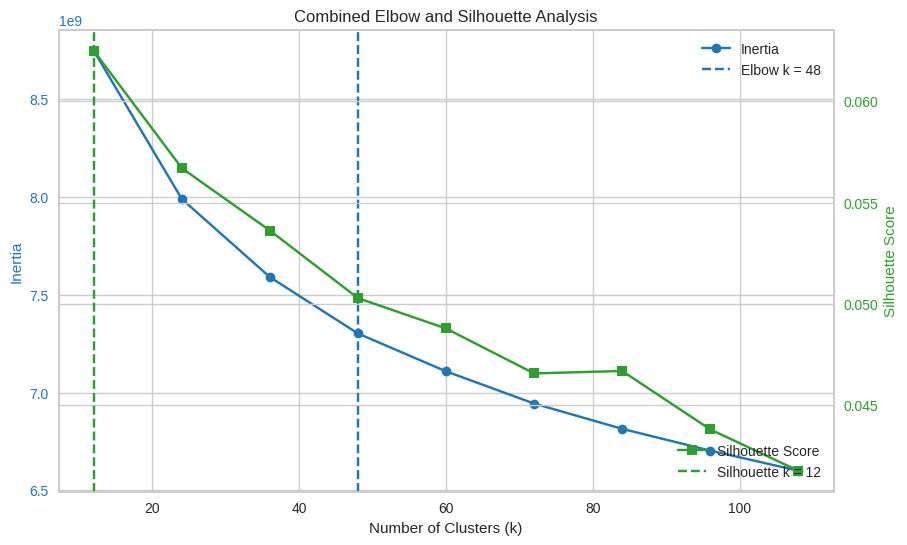

In [11]:

# k testing values
k_list = [x for x in range(12, 120, 12)]

inertia_values = []
silhouette_scores = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)

    # Inertia (cohesion)
    inertia_values.append(kmeans.inertia_)

    # Silhouette score (separation)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"For k = {k} | Silhouette Score = {score:.4f}")

# Find the knee by KneeLocator
kneedle = KneeLocator(k_list, inertia_values, curve='convex', direction='decreasing')
elbow_k = kneedle.knee

# Find the max Silhouette Score and its k value
best_silhouette_k = k_list[silhouette_scores.index(max(silhouette_scores))]

print("\n--- Summary ---")
print(f"Optimal k by Elbow Method: {elbow_k}")
print(f"Optimal k by Silhouette Score: {best_silhouette_k}")

# Elbow + Silhouette
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_list, inertia_values, marker='o', color=color, label='Inertia')
ax1.axvline(elbow_k, color=color, linestyle='--', label=f'Elbow k = {elbow_k}')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_list, silhouette_scores, marker='s', color=color, label='Silhouette Score')
ax2.axvline(best_silhouette_k, color=color, linestyle='--', label=f'Silhouette k = {best_silhouette_k}')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

plt.title('Combined Elbow and Silhouette Analysis')
plt.show()


In [ ]:
#### forse si può ottimizzare con il mini batch ma non aveo voglia di implentarlo

In [8]:
#Cluster descriptors per visual words (vocabulary)
k = 48  # fai altre prove se vuoi
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

#Assigmnet 2#
Represent each image of the training set as a normalized histogram having
k bins, each corresponding to a visual word; possibility is to perform a
rather dense sampling in space and scale; another possibility is to use the
SIFT detector to find the points in scale-space where the descriptor is
computed. In any case, each computed descriptor will increase the value
of the bin corresponding to the closest visual word.

In [14]:
def compute_histograms(images, visual_words):
    """
    Computes a normalized visual word histogram for each image in the dataset.

    Parameters:
        images (list of str): List of file paths to the images.
        visual_words (ndarray of shape (k, 128)):
            Array containing k visual words (cluster centroids) in SIFT descriptor space.

    Returns:
        histograms (list of ndarray): List of 1D histograms, one per image,
            representing the frequency of each visual word (normalized).
    """
    v = visual_words.shape[0]
    histograms = []

    for image_path in images:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)

        hist = np.zeros(v)

        if descriptors is not None:
            # descriptors: (n, 128), visual_words: (k, 128)
            distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
            # Fond for each descriptor the index of the closest visual word
            closest_words = np.argmin(distances, axis=1)
            # Increments the score of the bin = visual word,
            for idx in closest_words:
                hist[idx] += 1

        # Normalization
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        histograms.append(hist)

    return histograms


In [30]:
train_histograms = compute_histograms(images_training,visual_words)

In [9]:
def plot_bow_histogram(hist, title="Istogramma BoW", save_path=None, show_values=False):
    """
    Visualizza un istogramma BoW con etichette leggibili e layout ordinato.

    Args:
        hist (np.ndarray): Istogramma (array 1D) da visualizzare.
        title (str): Titolo del grafico.
        save_path (str): Se specificato, salva l'immagine su file.
        show_values (bool): Se True, mostra i valori sopra le barre.
    """
    k = len(hist)
    x = np.arange(k)

    plt.figure(figsize=(12, 4))
    bars = plt.bar(x, hist, color='skyblue', edgecolor='black')

    if show_values:
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:  # evita etichette inutili
                plt.text(bar.get_x() + bar.get_width() / 2.0, height,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel("Visual word ID")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(x)  # mostra tutte le parole visive
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Istogramma salvato in: {save_path}")
    else:
        plt.show()

    plt.close()


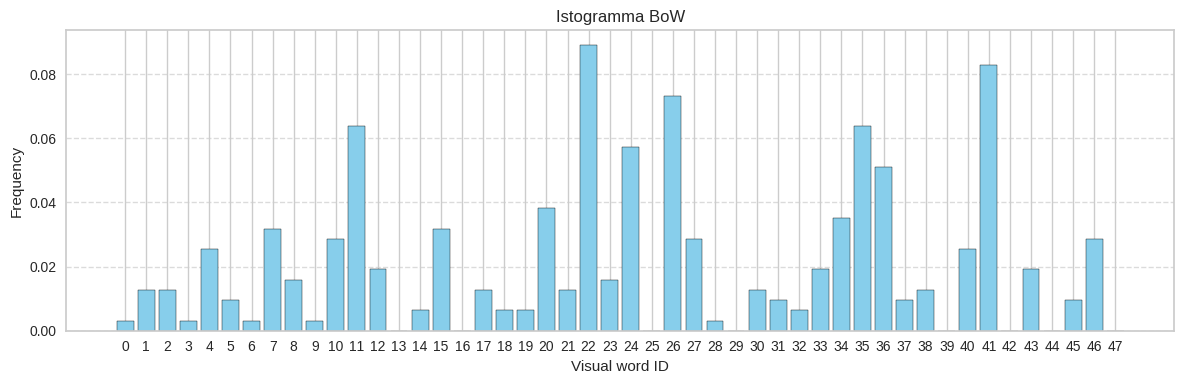

In [23]:
#plot a single histogram
plot_bow_histogram(train_histograms[7])

#Punto 3#

Employ a nearest neighbor classifier and evaluate its performance:


*   compute the normalized histogram for the test image to be classified;
*   assign to the image the class corresponding to the training image
having the closest histogram.
*   repeat for all the test images and build a confusion matrix.

In [25]:
# Loading test images
folder_test = '/content/drive/MyDrive/CV_progetto2/test'
images_test, test_labels  = load_images_labels(folder_test)

In [27]:
test_histograms = compute_histograms(images_test, visual_words)

**Comments**


---
It is necessary to convert the text labels into numeric form because the KNeighborsClassifier requires numerical input for the labels.

A grid search approach was used to find the optimal number of neighbors (k).
With a visual vocabulary of 48 visual words, the model reaches a performance plateau at around 38% accuracy and 37% macro F1-score for k = 21.

Some classes are easier to classify correctly than others:
* Forest achieves over 200 correct predictions,
*  Street over 140,
*  Suburb more than 130.

In contrast, other categories are more challenging. For example, Kitchen is often confused with Office or Living Room, with about 25 misclassifications for each and only around 9 correct predictions.

In [28]:
#label encoding training_labels text-numbers
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(train_labels)

In [31]:
#shuffle data
indices = list(range(len(train_labels)))
rd.shuffle(indices)
train_histograms = [train_histograms[i] for i in indices]
labels_train_encoded = [labels_train_encoded[i] for i in indices]
indices_test = list(range(len(test_labels)))
rd.shuffle(indices_test)
test_histograms = [test_histograms[i] for i in indices_test]
test_labels = [test_labels[i] for i in indices_test]

k = 5, accuracy = 0.3642, macro-F1 = 0.3367
k = 7, accuracy = 0.3779, macro-F1 = 0.3480
k = 9, accuracy = 0.3806, macro-F1 = 0.3488
k = 11, accuracy = 0.3849, macro-F1 = 0.3529
k = 13, accuracy = 0.3802, macro-F1 = 0.3488
k = 15, accuracy = 0.3765, macro-F1 = 0.3428
k = 17, accuracy = 0.3779, macro-F1 = 0.3432
k = 19, accuracy = 0.3776, macro-F1 = 0.3423
k = 21, accuracy = 0.3782, macro-F1 = 0.3416
k = 23, accuracy = 0.3792, macro-F1 = 0.3438
k = 25, accuracy = 0.3832, macro-F1 = 0.3484
k = 27, accuracy = 0.3789, macro-F1 = 0.3414
k = 29, accuracy = 0.3769, macro-F1 = 0.3380


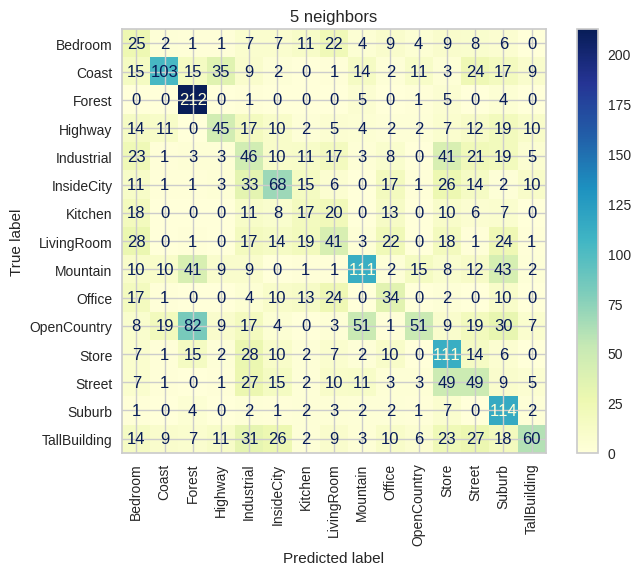

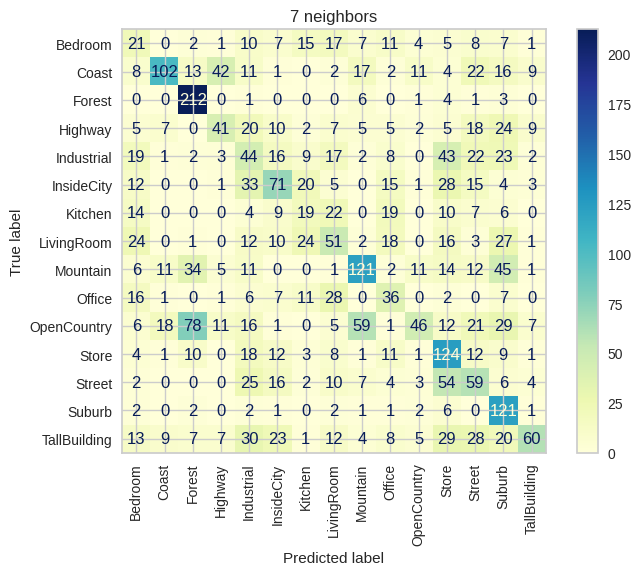

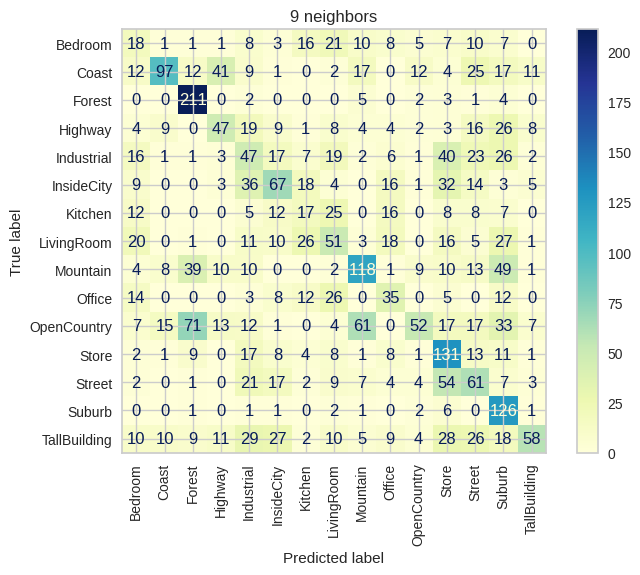

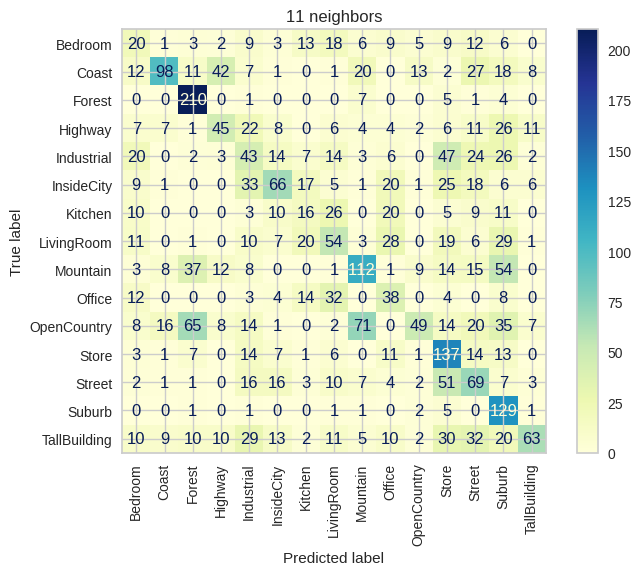

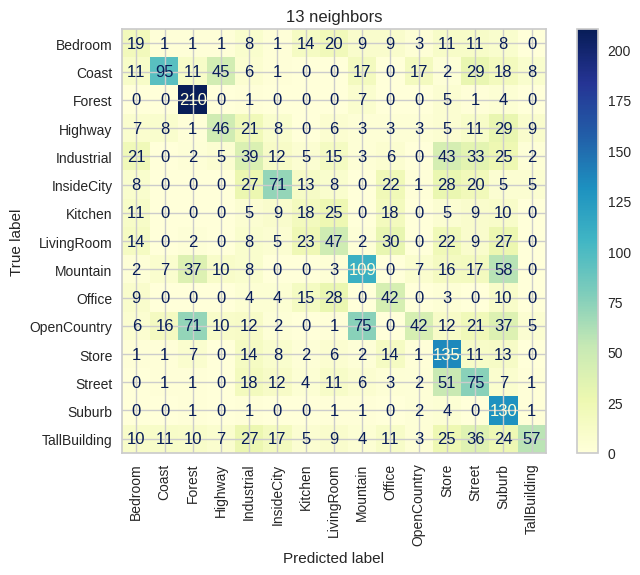

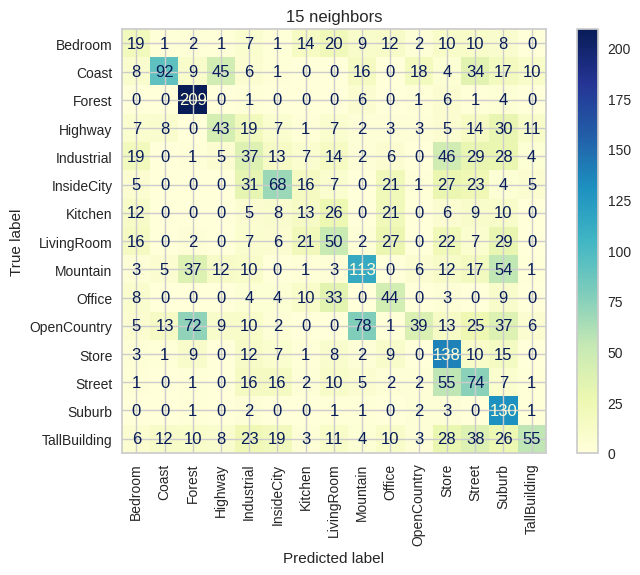

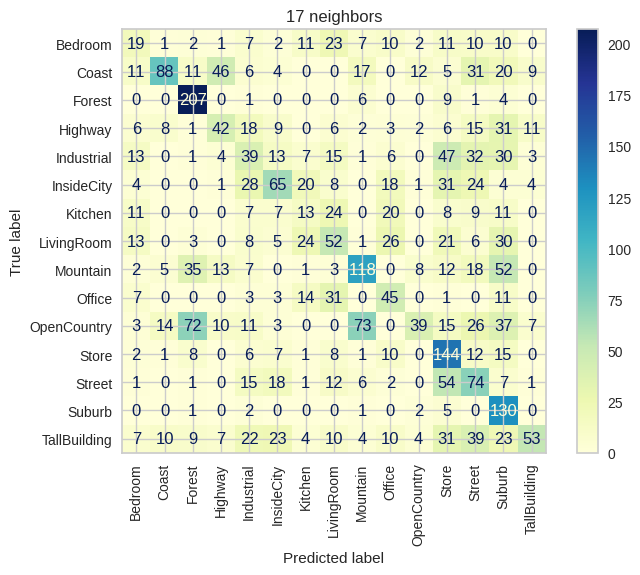

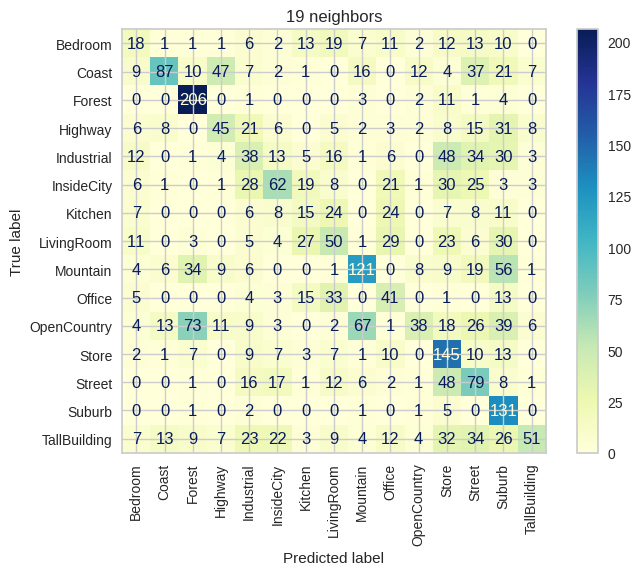

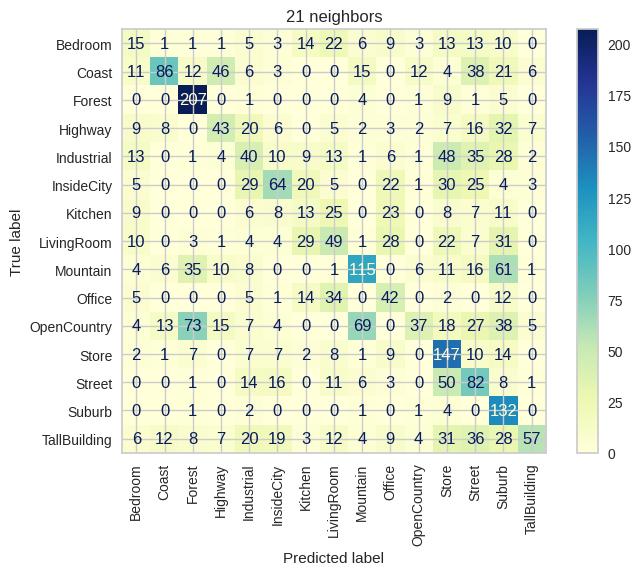

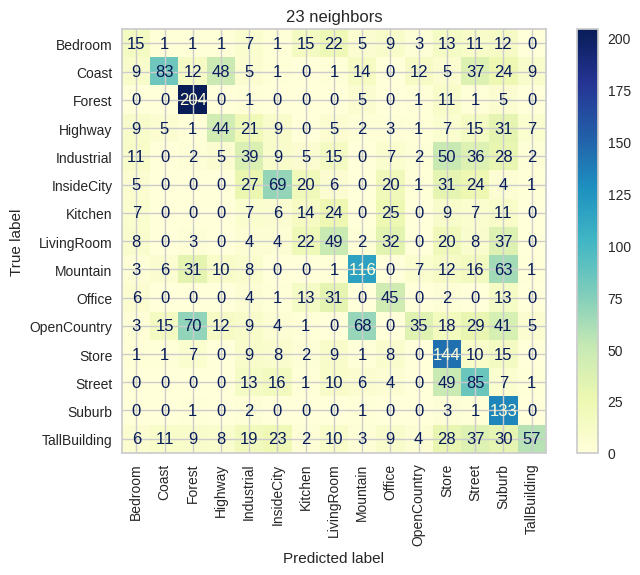

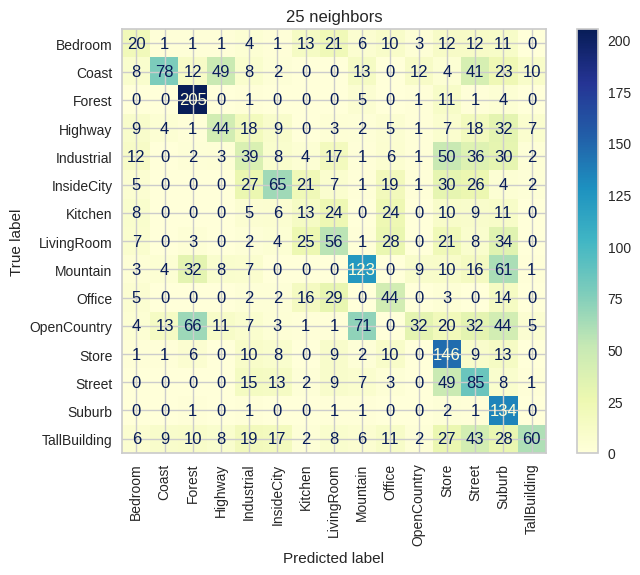

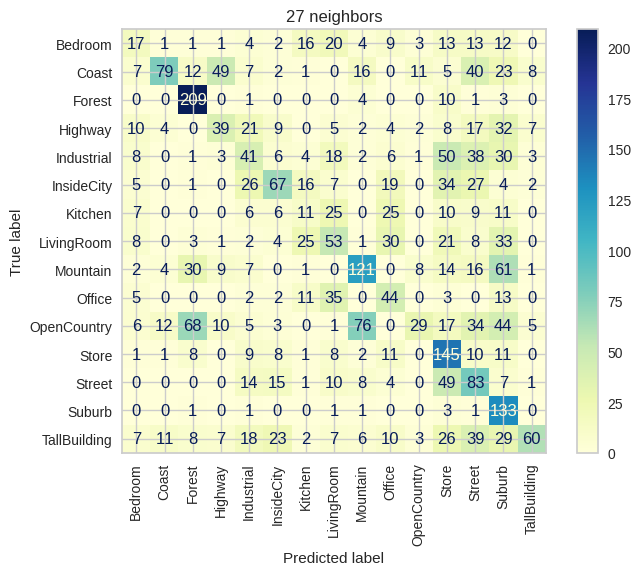

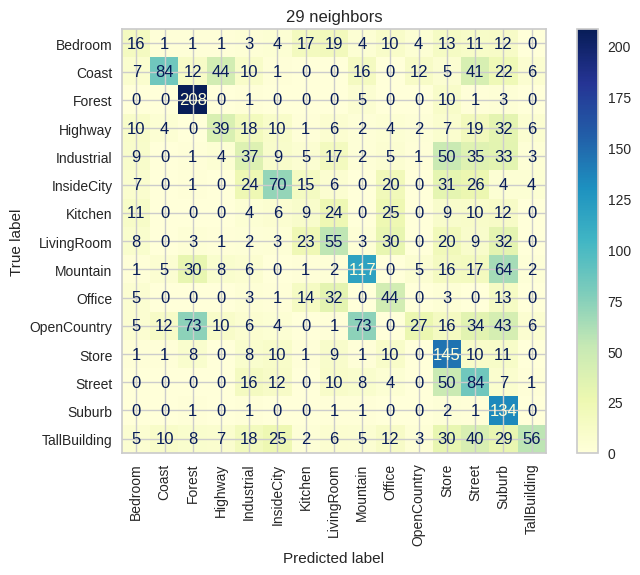

In [34]:
from sklearn.metrics import accuracy_score, f1_score
for k in range(5,30,2):
#training
  neigh = KNeighborsClassifier(n_neighbors=k) # Mikownski distance
  neigh.fit(train_histograms, labels_train_encoded)
#test phase
  predicted_labels = neigh.predict(test_histograms)
# confusion matrix
  predicted_labels = label_encoder.inverse_transform(predicted_labels)
  cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')
  cm_display.ax_.set_title(("{} neighbors").format(k))
  acc = accuracy_score(test_labels, predicted_labels)
  f1 = f1_score(test_labels, predicted_labels, average='macro')
  print(f"k = {k}, accuracy = {acc:.4f}, macro-F1 = {f1:.4f}")

#Assigment 4#
Train a multiclass linear Support Vector Machine, using the one-vs-rest
approach (you will need to train 15 binary classifiers having the normalized
histograms as the input vectors and positive labels for the “one” class and
negative for the “rest.”)

**Comments**


---


The labels are in textual form so to implement the correct procedure every label was encoded by the one-hot-encoded method

In [41]:
#training singole svm
from sklearn.utils import shuffle


X_train = np.array(train_histograms)
y_train = np.array(train_labels)
n_classes = len(np.unique(y_train))

#labels binarie
encoder = OneHotEncoder()
y_train_bin = encoder.fit_transform(y_train.reshape(-1, 1))
y_train_bin = y_train_bin.toarray()
X_train, y_train_bin = shuffle(X_train, y_train_bin, random_state=42)


classifiers = []
support_vectors = []
for i in range(n_classes):
    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train, y_train_bin[:,i])
    support_vectors.append(svm.support_vectors_)
    classifiers.append(svm)




#Assigment 5
Evaluate the multiclass SVM:
* compute the normalized histogram for the test image to be classified;
* compute the real-valued output of each of the SVMs, using that his-
togram as input;
* assign to the image the class corresponding to the SVM having the
greatest real-valued output.
* repeat for all the test images and build a confusion matrix.

#Comment


---
non so perchè la svm faccia così schifo prova a sistemare anche tu...


In [42]:
#test
X_test = np.array(test_histograms) #gli istogrammi sono stati generati in precedenza
predictions = []
# scores ha come righe le immagini di test, come colonne i classificatori, uso il trasposto per calcolare il max
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)

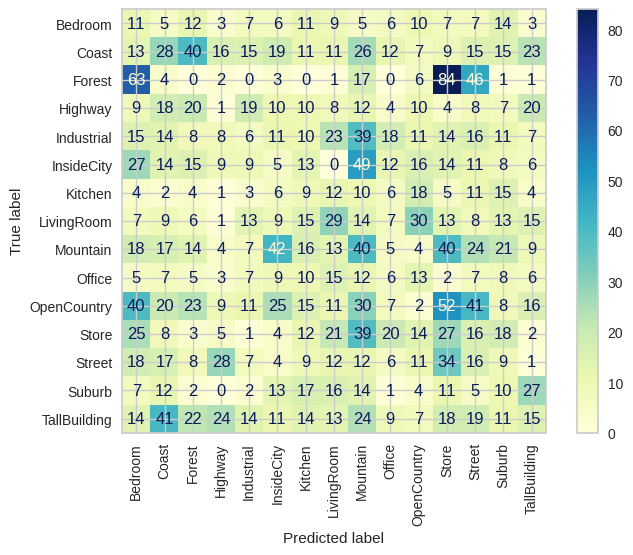

In [43]:
predictions = label_encoder.inverse_transform(predictions)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')

#Facoltativo#

**Punto 6**
Optionally, you could train the SVM using a generalized Gaussian kernel
(Lecture 7) based on the χ^2 distance;

da aggiunger grid search per A e tuning vari ma lo scheltro è giusto

In [ ]:
def chi_square_kernel(x_i, x, eps=1e-10, A=1.0):
    """
    Computes the Chi-square kernel between two vectors x_i and x.
    """
    chi_square_dist = np.sum(((x_i - x)**2) / (x_i + x + eps))
    #eps is to avoid 0/0
    return np.exp(-chi_square_dist/A)

In [ ]:
#training SVM
X_train = np.array(train_histograms)
K_train = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_train] for x_i in X_train])

In [ ]:
svm = SVC(kernel='precomputed')
classifiers_chi = []
#training di tutte e 15 le classi
for i in range(n_classes):
    svm.fit(K_train, y_train_bin[:,i])
    classifiers_chi.append(svm)

In [ ]:
#trovo i support vector per ottenere il kernerl precomputato necessario alla fase di test
predictions = []
for svm in classifiers_chi:
  support_vectors_indices = svm.support_
  support_vectors = X_train[support_vectors_indices]
  K_test = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_test] for x_i in support_vectors])

In [ ]:
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)

#Facoltativo: punto 7#
optionally, you could implement the multiclass SVM using the Error Cor-
recting Output Code approach [Dietterich and Bakiri, 1994, James and
Hastie, 1998];

#Comments


---

The image labels need to be rewritten as binary strings such that the Hamming distance between the columns that form them, as well as between individual columns and the complements of others, is large.
Since we have more than 11 classes, the Randomized Hill Climb algorithm can be implemented.

Multi-class SVM is implemented by default; the SVM function internally already uses a "one-vs-one" strategy.


In [45]:
def hamming_distance(matrix,min):
  '''
    funzione per calcolare la distanza di hamming minima
  '''
  # calcolo la distanza tra le righe (se uso matrix.T in input, tra le colonne)
  distances= np.array([
      distance.hamming(
          matrix[i], matrix[j])
          for i in range(matrix.shape[0])
          for j in range(matrix.shape[0])
          if i !=j ])
  if min == True:
    min_distance = np.min(distances)
    min_index = np.argmin(distances)
    i_min = min_index // matrix.shape[0]
    j_min = min_index % matrix.shape[0]
    return min_distance, i_min, j_min
  else:
    max_distance = np.max(distances)
    max_index = np.argmax(distances)
    i_max = max_index // matrix.shape[0]
    j_max = max_index % matrix.shape[0]
    return max_distance, i_max, j_max


In [ ]:
#Randomize Hill Climb
import random
import scipy.spatial.distance as distance
from itertools import combinations

n_class = 15
n_col = 20 #numero a caso per adesso non ho capito se ce sia una strategia per deciderla
labels_RHC = np.random.randint(0,2,size=(n_class,n_col))
print(labels_RHC)
for l in range (0,100,1):
  # calcolo la distanza di Hamming minma globale (criterio di stop)


  # trovo le righe con la minima distanza di Hamming
  min_dist_row, i_min, j_min = hamming_distance(labels_RHC,min)

  # trovo le colonne con la massima distanza di Hamming (si può fare anche con il minimo basta che siano estremi)
  max_dist_col, i_max, j_max = hamming_distance(labels_RHC.T,max)

  # trovo il minimo globale come trheshold:
  min_dist_col, i_mc, j_mc = hamming_distance(labels_RHC,min)
  min_dist = min(min_dist_row,min_dist_col)

  # modifico 2 dei 4 punti tra righe e colonne
  common_bits = [(i_min,j_max),(i_min,i_max),(j_min,j_max),(j_min,i_max)]
  print(common_bits)
  bit_combinations = list(combinations(common_bits, 2))
  indx = 0
  for pair in bit_combinations:
    (i, j),(k,l) = pair
    indx += 1
    labels_RHC[i,j] =  1 - labels_RHC[i,j]
    labels_RHC[k,l] =  1 - labels_RHC[k,l]
    min_row, i_mr, j_mr = hamming_distance(labels_RHC,min)
    min_col, i_mc, j_mc = hamming_distance(labels_RHC.T,min)
    new_min_dist = min(min_row,min_col)
    if new_min_dist <= min_dist and indx==len(bit_combinations):
      #print("massimo locale {},{}".format(new_min_dist,min_dist))
      i = np.random.randint(0,n_class-1)
      j = np.random.randint(0,n_class-1)
      k = np.random.randint(0,n_col-1)
      l = np.random.randint(0,n_col-1)
      labels_RHC[i,k] =  1 - labels_RHC[i,k]
      labels_RHC[j,k] =  1 - labels_RHC[j,k]
      labels_RHC[i,l] =  1 - labels_RHC[i,l]
      labels_RHC[j,l] =  1 - labels_RHC[j,l]
    else:
      continue

print(labels_RHC)

#non sono sicura che l'ultima parte si comporti come deve...

In [51]:
#implemento la MSVM
from sklearn.datasets import make_multilabel_classification

# RHC conversion
label_to_index = {label: i for i, label in enumerate(labels)}
train_label_encoded = np.array([
    labels_RHC[label_to_index[train_label]] for train_label in train_labels
])

# training
svc = SVC(kernel='linear')
svc.fit(train_histograms, train_label_encoded)

# test
Y_pred = svc.predict(test_histograms)


In [ ]:
#non so ho trovato anche la funzione ma non so come funzioni
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC
clf = OutputCodeClassifier(LinearSVC(random_state=0), code_size=2, random_state=0)  #code_size andrà cambiato
clf.fit(images_training, train_labels).predict(images_training)

#Facoltativo: punto 8#
optionally, you could use soft assignment to assign descriptors to histogram
bins. Each descriptor will contribute to multiple bins, using a distance-
based weighting scheme (see [Van Gemert et al., 2008]);

(nel paper sonon present altri due modi per adesso ho capito questo)

**Comments**

soft assignment:

*   nella versione 1: $\frac{1}{n}∑_{i=1}^{n} K_{σ}(x-X_i)$
dove n è in numero di samples, $X_{i}$ è l'i-esimo sample $K_{σ} = \frac{1}{\sqrt{2π}σ} \mathrm{e}^{\frac{x^2}{2σ^2}}$
   



In [13]:
def compute_soft_histograms(images,visual_words):
    """
      Computes soft-assignment histograms of visual words for a list of images.

      Instead of assigning each SIFT descriptor to the closest visual word (hard assignment),
      this function uses a Gaussian kernel to softly assign each descriptor to multiple visual words,
      weighted by their distance. This results in a smoother, more robust histogram representation.

      Parameters:
          images (list of str): List of file paths to input images.
         visual_words (ndarray of shape (k, 128)): Array of k cluster centroids (visual words) in SIFT descriptor space.

      Returns:
            histograms (list of ndarray): List of normalized soft-assignment histograms, one per image.
            Each histogram reflects the weighted frequency of visual words in the image.
    """
    v = visual_words.shape[0]
    histograms = []
    sigma = 100 #da fare il tuning
    #soft_kernel= (1/np.sqrt(2*np.pi))*np.exp(-(visual_words**2)/(2*sigma**2))

    for image_path in images:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)

        hist = np.zeros(v)

        if descriptors is not None:
            # descriptors: (n, 128), visual_words: (k, 128)
            distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
            # moltiplico per il kernel gaussiano così che ogni descrittore voti per più bin
            words_distribution = (1/np.sqrt(2*np.pi))*np.exp(-(distances**2)/(2*sigma**2))
            #sommo su tutti i descrittori
            hist = np.sum(words_distribution, axis=0)

        # Normalizzazione
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        histograms.append(hist)

    return histograms


In [14]:
soft_histograms = compute_soft_histograms(images_training,visual_words)

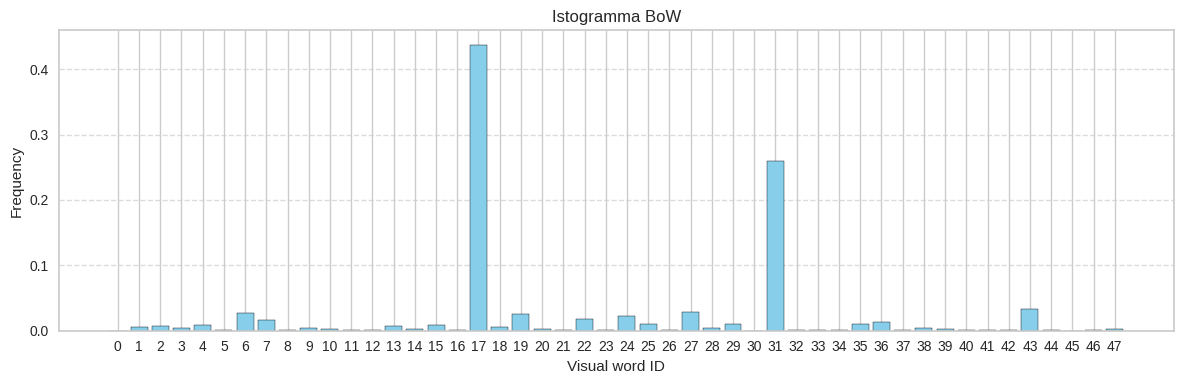

In [15]:
plot_bow_histogram(soft_histograms[6])

#Facoltativo: punto 9#
optionally, you could add some spatial information by taking inspiration
from the spatial pyramid feature representation of [Lazebnik et al., 2006]
(a simple approach could be that of building an extended descriptor, by
stacking the histogram of the whole image, the histograms of the 4 quad-
rants and so on, up to a desired level).

# seguendo il paper la procedura è (è stato usato il sift):

Train a classifier like:
1.  Extract dense features + (x, y) locations
2.  Quantize to visual words (k-means)
(il vocabolario che abbiamo già)
3.  Build histograms per spatial cell at each level
4.  Multiply each histogram by its pyramid weight
5.  Concatenate all histograms into a single vector
6.  Normalize the entire vector by its total mass (sum of bins)
7.  Stack all image vectors into matrix X

per il classificatore posso usare sia una snm lineare o un kernel apposito


In [ ]:

def extract_sift_from_cell(subimg, visual_words):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(subimg, None)
    v = visual_words.shape[0]
    hist = np.zeros(v)

    if descriptors is not None:
      # descriptors: (n, 128), visual_words: (k, 128)
      distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
      # Trova per ogni descrittore l'indice della visual word più vicina
      closest_words = np.argmin(distances, axis=1)
      # Aumento il bin = visual word, dell'istogramma
      for idx in closest_words:
          hist[idx] += 1

    return hist

def spatial_pyramid_per_cell(image, kmeans, vocab_size, max_level=2):
    """
    Extract features by splitting the image into subimages per cell,
    and extracting SIFT independently per cell.
    """
    h, w = image.shape[:2]
    pyramid_vector = []

    for level in range(1,max_level + 1):
        num_cells = 2 ** level
        cell_h = h // num_cells
        cell_w = w // num_cells
        weight = 1.0 / (2 ** (max_level - level))

        for i in range(num_cells):
            for j in range(num_cells):
                y_start = i * cell_h
                y_end = (i + 1) * cell_h if i != num_cells - 1 else h

                x_start = j * cell_w
                x_end = (j + 1) * cell_w if j != num_cells - 1 else w

                cell_img = image[int(y_start):int(y_end), int(x_start):int(x_end)]
                hist = extract_sift_from_cell(cell_img, visual_words)
                pyramid_vector.append(hist * weight)

    # Final concatenated and normalized feature vector
    final_vector = np.concatenate(pyramid_vector)
    total = final_vector.sum()
    if total > 0:
        final_vector /= total

    return final_vector


In [ ]:
#Kernel apposito (?)
